In [ ]:
from Functions import extractData, correlation
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import datetime
###Feature Extraction
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import MinimalFCParameters, from_columns
###SCALING
from sklearn.preprocessing import MinMaxScaler
###MODEL
from keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping

In [ ]:
### select number of valve
n = 5

In [ ]:
### select training period
start = '2019-12-03 00:00:00'
end = '2019-12-10 23:55:00'

In [ ]:
### Creating directory
dirs = "/Valve" + str(n)+ "/"
mydir = os.path.join(dirs, datetime.datetime.now().strftime('%Y/%m/%d_%H-%M-%S'))
os.makedirs(mydir)

In [ ]:
### import data
df5_train = extractData(n, start, end)

In [ ]:
### data segmentation - rolled window
window_size = 60
df5_train_rolled = roll_time_series(df5_train, column_id="id", column_sort="date",column_kind=None, rolling_direction=1, max_timeshift=(window_size-1))

In [ ]:
### extract minimal set of features
settings_minimal = MinimalFCParameters()
df5_train_feat = extract_features(df5_train_rolled , column_id='id', column_sort='date', n_jobs=0, default_fc_parameters=settings_minimal, impute_function=impute)
df5_train_filtered = correlation(df5_train_feat, 0.99)

In [ ]:
### reduced feature extraction
kind_to_fc_parameters = from_columns(df5_train_filtered)
df5_train_min = extract_features(df5_train_rolled, column_id='id', column_sort='date', n_jobs=0, kind_to_fc_parameters=kind_to_fc_parameters, impute_function=impute)

In [ ]:
### save parameters
with open(mydir+ "/parameters.pkl", "wb") as outfile:
   pkl.dump(kind_to_fc_parameters, outfile)

In [ ]:
### scale Data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(df5_train_min)

In [ ]:
### reshaped data to 3D tensor
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [ ]:
### define the autoencoder network model
def autoencoder_model_LSTM(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(10, activation= 'softmax', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.001), dropout=0.5)(inputs)
    L2 = LSTM(2, activation= 'softmax', return_sequences=False, dropout=0.5)(L1)
    L3 = RepeatVector(X_train.shape[1])(L2)
    L4 = LSTM(2, activation= 'softmax', return_sequences=True)(L3)
    L5 = LSTM(10, activation= 'softmax', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X_train.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
### create the autoencoder model
model = autoencoder_model_LSTM(X_train)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

In [ ]:
### Early Stopping
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0.1, mode='auto')

In [ ]:
#### fit the model to the data
nb_epochs = 100
batch_size = 60
history = model.fit(X_train, X_train, epochs=nb_epochs,batch_size= batch_size,  validation_split=0.2, callbacks=[es]).history

In [ ]:
### plot the training losses
fig, ax = plt.subplots()
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
### plot the loss distribution of the training set
X_pred1 = model.predict(X_train)
X_pred1 = X_pred1.reshape(X_pred1.shape[0], X_pred1.shape[2])
X_pred1 = pd.DataFrame(X_pred1, columns=df5_train_min.columns)
X_pred1.index = df5_train_min.index

scored = pd.DataFrame(index=df5_train_min.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mse'] = (np.square(X_pred1 - Xtrain)).mean(axis=1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mse'], kde= True, color = 'blue')
plt.show()

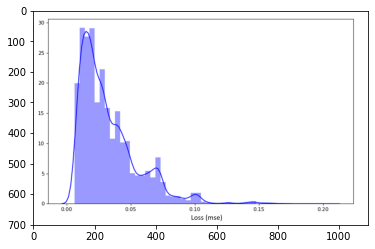

In [4]:
plt.imshow(img)

In [ ]:
### Get reconstruction loss treshold
threshold = np.max(scored['Loss_mse'])
print("Reconstruction error threshold: ", threshold)
### save threshold
with open(mydir + "/threshold.pkl", "wb") as outfile:
   pkl.dump(threshold, outfile)

In [ ]:
### save all model information, including weights, in h5 format
model.save(mydir + "/model.h5")
print("Model saved")